In [7]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.append(str(Path.cwd()))
from plotting_constants import colors

from data_path import DATA_PATH as root

root = root / "joint_data"

idx = pd.IndexSlice

In [8]:
year = 2035

def get_load(year, mode, carrier):
    load = pd.read_csv(root / "nodal_loads.csv", index_col=[0,1], header=list(range(9)))

    load = load.loc[idx[:,carrier], idx[:, :, :, :, str(year), mode, "static", :, :]].copy()
    load.index = load.index.get_level_values(0)

    assert load.shape[1] == 1
    load.columns = [carrier]

    return load

In [9]:
def get_gen(year, mode, carrier):

    cap = pd.read_csv(root / "nodal_capacities.csv", index_col=[0,1,2], header=list(range(9)))

    if isinstance(carrier, str):
        carrier = [carrier]
    
    cap = cap.loc[idx[:,:,carrier], idx[:,:,:,:,str(year),mode,"static",:,:]].copy()
    cap.index = cap.index.droplevel(0)
    cap = cap.unstack()
    cap.columns = carrier

    return cap.fillna(0)

In [10]:
geo = pd.read_csv(root / "nodal_geothermal_stats.csv", index_col=[0,1], header=list(range(9)))

In [11]:
def get_costs(year):
    fn = root.parent / "egs_costs_s_72_{}.csv".format(year)
    costs = pd.read_csv(fn).set_index("name")["capex_mean"]

    return costs

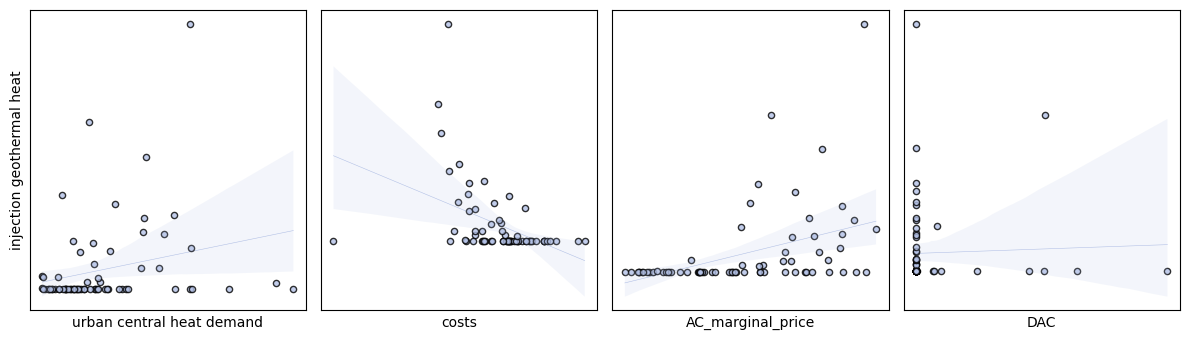

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler
geo.index.get_level_values(0).unique()

carriers = [
    "onwind",
    "offwind-ac",
    "injection geothermal heat",
    "urban central solar thermal",
    "solar",
    "solar rooftop",
    "DAC",
    "urban central water tanks charger",
    "urban central water tanks",
    "H2 Store",
    "electricity distribution grid",
]

def match_index(df, name):
    df.index = df.index.get_level_values(0)
    df.columns = [name]
    return df

years = {
    "dh": "2040",
    "chp": "2050",
    "elec": "2050",
}


def prep_data(mode, year):

    data = pd.DataFrame(index=geo.index.get_level_values(0).unique())

    data[carriers] = get_gen(year, mode, carriers)
    data["electricity demand"] = get_load(year, mode, "electricity")
    data["urban central heat demand"] = get_load(year, mode, "urban central heat")

    name = "dac_stats"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "dac"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "onwind cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "onwind"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "offwind-ac cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "offwind-ac"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "solar cp"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, "solar"], idx[:, :, :, :, year, mode, "static", :, :]].copy(), name)

    name = "AC_marginal_price"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, name], idx[:, :, :, :, "2020", mode, "static", :, :]].copy(), name)

    name = "uch_marginal_price"
    data.loc[:, [name]] = match_index(geo.loc[idx[:, name], idx[:, :, :, :, "2020", mode, "static", :, :]].copy(), name)

    data["costs"] = get_costs(years[mode])

    data["total cp sum"] = data["onwind cp"] + data["solar cp"]    
    data["total cp mul"] = data["onwind cp"] * data["solar cp"]    

    o = StandardScaler().fit_transform(data[['onwind cp']])
    s = StandardScaler().fit_transform(data[['solar cp']])

    data["total cp manual"] = (o + s)**2

    return data


fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))

# modes = ["dh", "elec", "chp"]
modes = ["elec"]

for i, mode in enumerate(modes):

    
    data = prep_data(mode, years[mode])
    data = data.fillna(0)
    data.drop('IT1 4', inplace=True)

    if mode != "elec":
        data = data.sort_values(by="injection geothermal heat", ascending=True).iloc[:-1]    

    y = MinMaxScaler().fit_transform(data[["injection geothermal heat"]])
    X = data.drop(columns=["injection geothermal heat"])

    chosen = ["urban central heat demand", "costs", "AC_marginal_price", "DAC"]

    for i, (col, ax) in enumerate(zip(chosen, axs)):
        ax.set_xlabel(col)

        d = pd.DataFrame({'y': y.flatten(), 'x': data[col].values})

        pdata = d.loc[d["y"] > 0.]

        sns.regplot(
            data=pdata, x='x', y='y', ax=ax, color=colors[mode],
            line_kws={"linewidth": 0.4, "zorder": 0},
            scatter_kws={"s": 20, "alpha": 0.8, "edgecolor": "k"}
            )

        ax.set_xlabel(col)
        ax.set_xticks([])
        ax.set_yticks([])


axs[0].set_ylabel("injection geothermal heat")
for ax in axs[1:]: ax.set_ylabel("")
for ax in axs: ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import pearsonr

rs = list()
ps = list()

for col in data.columns:
    ss = pd.concat([data["injection geothermal heat"], data[col]], axis=1).dropna()
    print(f'Share considered for col {col}:', ss.shape[0] / data.shape[0])
    r, p = pearsonr(ss.iloc[:,0], ss.iloc[:,1])
    rs.append(r)
    ps.append(p)

rs = pd.Series(rs, index=data.columns)
ps = pd.Series(ps, index=data.columns)

Share considered for col onwind: 1.0
Share considered for col offwind-ac: 1.0
Share considered for col injection geothermal heat: 1.0
Share considered for col urban central solar thermal: 1.0
Share considered for col solar: 1.0
Share considered for col solar rooftop: 1.0
Share considered for col DAC: 1.0
Share considered for col urban central water tanks charger: 1.0
Share considered for col urban central water tanks: 1.0
Share considered for col H2 Store: 1.0
Share considered for col electricity distribution grid: 1.0
Share considered for col electricity demand: 1.0
Share considered for col urban central heat demand: 1.0
Share considered for col dac_stats: 1.0
Share considered for col onwind cp: 1.0
Share considered for col offwind-ac cp: 1.0
Share considered for col solar cp: 1.0
Share considered for col AC_marginal_price: 1.0
Share considered for col uch_marginal_price: 1.0
Share considered for col costs: 1.0
Share considered for col total cp sum: 1.0
Share considered for col total 

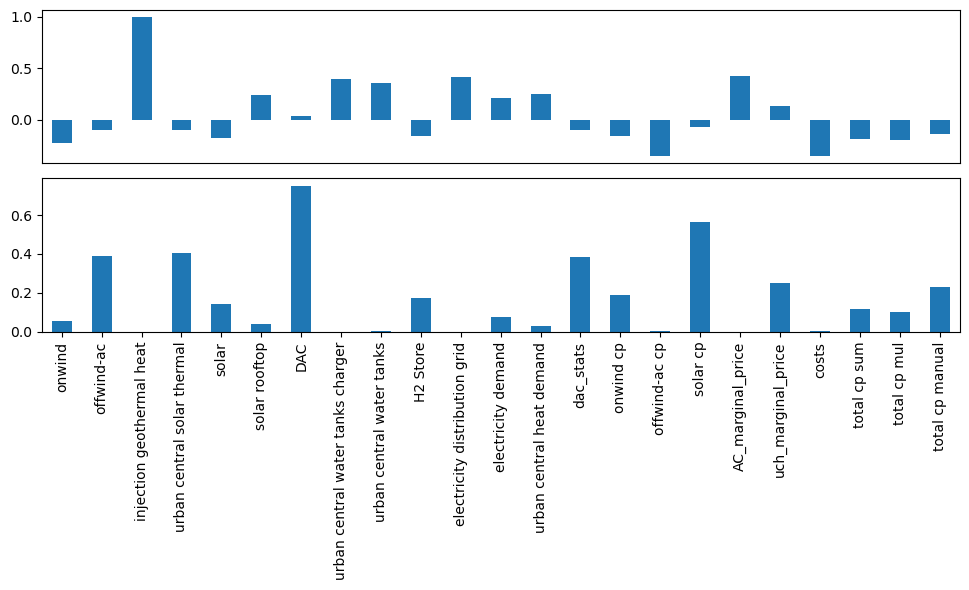

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

rs.plot(kind="bar", ax=axs[0])
ps.plot(kind="bar", ax=axs[1])

axs[0].set_xticks([])

plt.tight_layout()
plt.show()

In [16]:
considered = [
    # 'onwind',
    # 'solar',
    # 'DAC',
    #'electricity distribution grid',
    'electricity demand',
    'urban central heat demand',
    'onwind cp',
    'solar cp',
    'AC_marginal_price',
    'uch_marginal_price',
    'costs',
    ]

feature_nice_names = {
    "onwind": "Onshore Wind\nCapacity",
    "solar": "Solar PV\nCapacity",
    "DAC": "Direct Air Capture\nCapacity",
    "electricity distribution grid": "Distribution Grid\nCapacity",
    "electricity demand": "Electricity\nDemand",
    "urban central heat demand": "District\nHeat Demand",
    "onwind cp": "Onshore Wind\nCapacity Factor",
    "solar cp": "Solar PV\nCapacity Factor",
    "AC_marginal_price": "Electricity\nMarginal Price",
    "total cp sum": "Sum of Wind&Solar\nCapacity Factors",
    "total cp manual": "Fct of Wind&Solar\nCapacity Factors",
    "uch_marginal_price": "District Heat\nMarginal Price",
    "costs": "Drilling Costs",
}

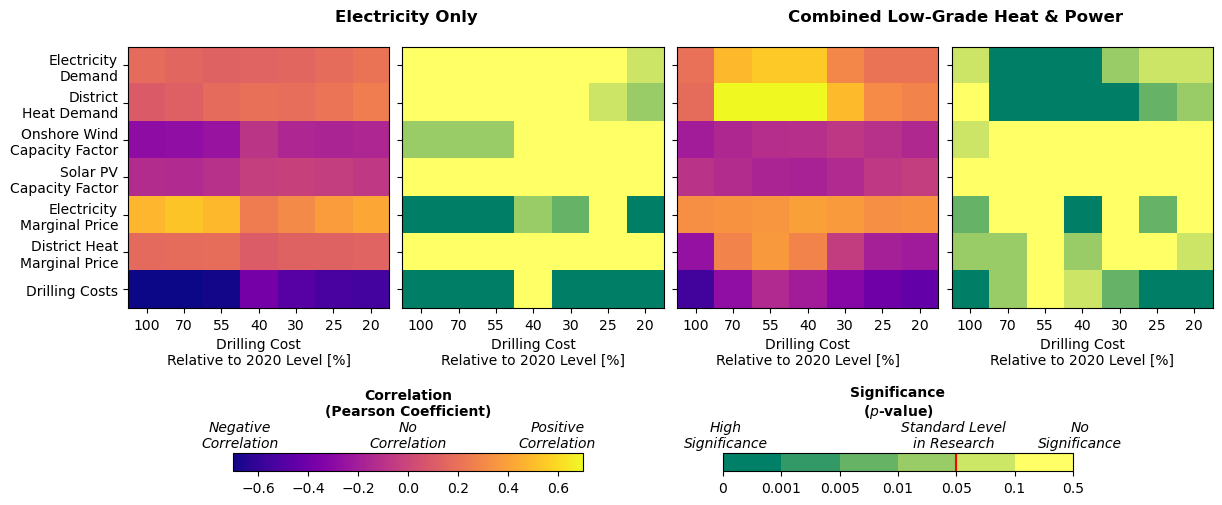

In [17]:
nice_names = {
    # "elec": "Electricity\nOnly",
    "elec": "Electricity Only",
    # "chp": "Combined Low-Grade\nHeat & Power",
    "chp": "Combined Low-Grade Heat & Power",
    "dh": "Low-Grade\nHeat Only",
}

import sys
sys.path.append(str(Path.cwd()))

from plotting_constants import xaxis_mapper

import matplotlib as mpl
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, IndexLocator

all_years = ["2020", "2025", "2030", "2035", "2040", "2045", "2050"]
all_modes = ["elec", "chp", "dh"]

feature_name = "urban central heat"

vmaxs = {
    "urban central heat": 0.7,
    "electricity": 0.7,
    "cost": 0.,
}
vmins = {
    "urban central heat": 0.,
    "electricity": 0.,
    "cost": -1.,
}

cax_height = 0.015
cax_ypos = 0.25

# cmap = "plasma"
# mode = "dh"

fig, axss = plt.subplots(1, 4, figsize=(14, 12))
mode1 = 'elec'
mode2 = 'chp'

for k, (mode, ax1, ax2) in enumerate(
    zip(
        [mode1, mode2],
        [axss[0], axss[2]],
        [axss[1], axss[3]]
        )):

    rs = pd.DataFrame(index=all_years, columns=considered)
    ps = pd.DataFrame(index=all_years, columns=considered)

    for year in all_years:

        data = prep_data(mode, year)
        data.drop('IT1 4', inplace=True)
        for feature_name in considered:

            feature = data[feature_name].dropna()
            target = data['injection geothermal heat'].loc[feature.index]

            rs.loc[year, feature_name], ps.loc[year, feature_name] = pearsonr(feature, target)

    vmin = -0.7
    vmax = 0.7
    cax_size = '5%'

    im0 = ax1.imshow(rs.astype(float).T, cmap='plasma', vmin=vmin, vmax=vmax)
    if k == 0:
        cax = fig.add_axes([0.2, cax_ypos, 0.25, cax_height])

        fig.colorbar(im0, cax=cax, orientation='horizontal')
        cax.xaxis.set_ticks_position('bottom')

        cax.annotate(
            "Correlation\n(Pearson Coefficient)",
            xy=(0.5, 1.),
            xytext=(0.5, 3.8),
            xycoords="axes fraction",
            textcoords="axes fraction",
            ha="center",
            va="center",
            fontsize=10,
            color="k",
            fontweight='bold',
            )

    ps = ps.values.astype(float).T
    borders = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]

    for i in range(len(borders) - 1):
        ps[(ps > borders[i]) & (ps <= borders[i+1])] = i

    cmap = plt.cm.summer  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, 6)

    im1 = ax2.imshow(ps, cmap=cmap, vmin=0., vmax=ps.max())

    if k == 0:

        cax = fig.add_axes([0.55, cax_ypos, 0.25, cax_height])

        fig.colorbar(im1, cax=cax, orientation='horizontal')
        cax.xaxis.set_ticks_position('bottom')

        cax.annotate(
            "Significance\n"+r"($p$-value)",
            xy=(0.5, 1.),
            xytext=(0.5, 3.8),
            xycoords="axes fraction",
            textcoords="axes fraction",
            ha="center",
            va="center",
            fontsize=10,
            color="k",
            fontweight='bold',
            )

        cax.xaxis.set_major_locator(FixedLocator(range(len(borders))))
        cax.set_xticklabels([str(b) for b in borders])

for ax in axss[1:]:
    ax.set_yticklabels([])

axss[0].yaxis.set_major_locator(FixedLocator(range(len(considered))))
axss[0].set_yticklabels([feature_nice_names[col] for col in considered])

for ax in axss:
    ax.xaxis.set_major_locator(FixedLocator(range(len(all_years))))
    ax.set_xticklabels(['100', '70', '55', '40', '30', '25', '20'])
    ax.set_xlabel("Drilling Cost\nRelative to 2020 Level [%]")

axss[0].text(
    len(all_years)-0.05,
    -1.3,
    nice_names[mode1],
    ha="center",
    va="center",
    fontsize=12,
    fontweight="bold",
    )
axss[2].text(
    len(all_years)-0.05,
    -1.3,
    nice_names[mode2],
    ha="center",
    va="center",
    fontsize=12,
    fontweight="bold",
    )
plt.subplots_adjust(wspace=0.05)

texts = [
    'Negative\nCorrelation',
    'No\nCorrelation',
    'Positive\nCorrelation',
    'High\nSignificance',
    'Standard Level\nin Research',
    'No\nSignificance',
]
xs = [
    2.5, 7, 11, 15.5, 21.6, 25
]

for t, x in zip(texts, xs):

    axss[0].text(
        x,
        9.9,
        t,
        ha="center",
        va="center",
        fontsize=10,
        fontstyle='italic',
        )
cax.axvline(4, color='r')

plt.savefig('correlation_imshows.pdf', bbox_inches='tight')

plt.show()